In [ ]:
!gunzip pacbio_40x.fq.gz
!gunzip ONT_2D.fastq.gz

### 0. Разобраться с minimap2

In [3]:
!minimap2 -a reference.fasta pacbio_40x.fq > alignment1.sam
!minimap2 -a reference.fasta ONT_2D.fastq > alignment2.sam

[M::mm_idx_gen::0.167*1.39] collected minimizers
[M::mm_idx_gen::0.277*1.12] sorted minimizers
[M::main::0.277*1.12] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.292*1.11] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.302*1.11] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::168.773*0.95] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -a reference.fasta pacbio_40x.fq
[M::main] Real time: 168.798 sec; CPU: 160.122 sec; Peak RSS: 1.974 GB
[M::mm_idx_gen::0.168*1.00] collected minimizers
[M::mm_idx_gen::0.286*0.87] sorted minimizers
[M::main::0.286*0.87] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.309*0.84] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.324*0.84] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.0

In [4]:
!samtools flagstat alignment1.sam

49743 + 0 in total (QC-passed reads + QC-failed reads)
1528 + 0 secondary
6768 + 0 supplementary
0 + 0 duplicates
48434 + 0 mapped (97.37% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [5]:
!samtools flagstat alignment2.sam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### 1. Статистики ридов PacBio и Oxford Nanopores.


- Покрытие генома

In [18]:
import pysam as ps
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import time
from progress.bar import IncrementalBar
from tqdm import tqdm
from collections import Counter

In [7]:
def coverage(sam, fasta):
    align = ps.AlignmentFile(sam, 'rb')
    reference = SeqIO.read(fasta, 'fasta').seq
    cov = {}
    
    for read in tqdm(align.fetch()):
        start, end = read.reference_start, read.reference_end
        if start and end:
            for i in range(start, end):
                if i in cov:
                    cov[i] += 1
                else:
                    cov[i] = 1
            
    return cov

In [8]:
cov_dataset1 = coverage('alignment1.sam', 'reference.fasta')

49743it [02:19, 355.75it/s]


In [9]:
cov_dataset2 = coverage('alignment2.sam', 'reference.fasta')

32103it [02:12, 242.49it/s]


In [10]:
reference = SeqIO.read('reference.fasta', 'fasta').seq

In [11]:
def graphics(cov):
    positions,c =  list(cov.keys()), list(cov.values())
    
    fig = plt.figure(figsize=(15, 15))
    
    plt.xlabel('Позиция', fontsize=20, color='green')
    plt.ylabel('Количество ридов', fontsize=20, color='green')
    plt.rcParams.update({'font.size': 20})
    
    plt.plot(positions, c, color='green', linewidth = 0, marker = 'o', 
             markersize = 5, markerfacecolor = 'lawngreen',
             markeredgecolor = 'limegreen', markeredgewidth = 0.5)
    plt.grid()

Для первого набора данных имеем следующую статистику:

Среднее покрытие  40.051676044480715
Процент покрытого генома  99.9999784467662


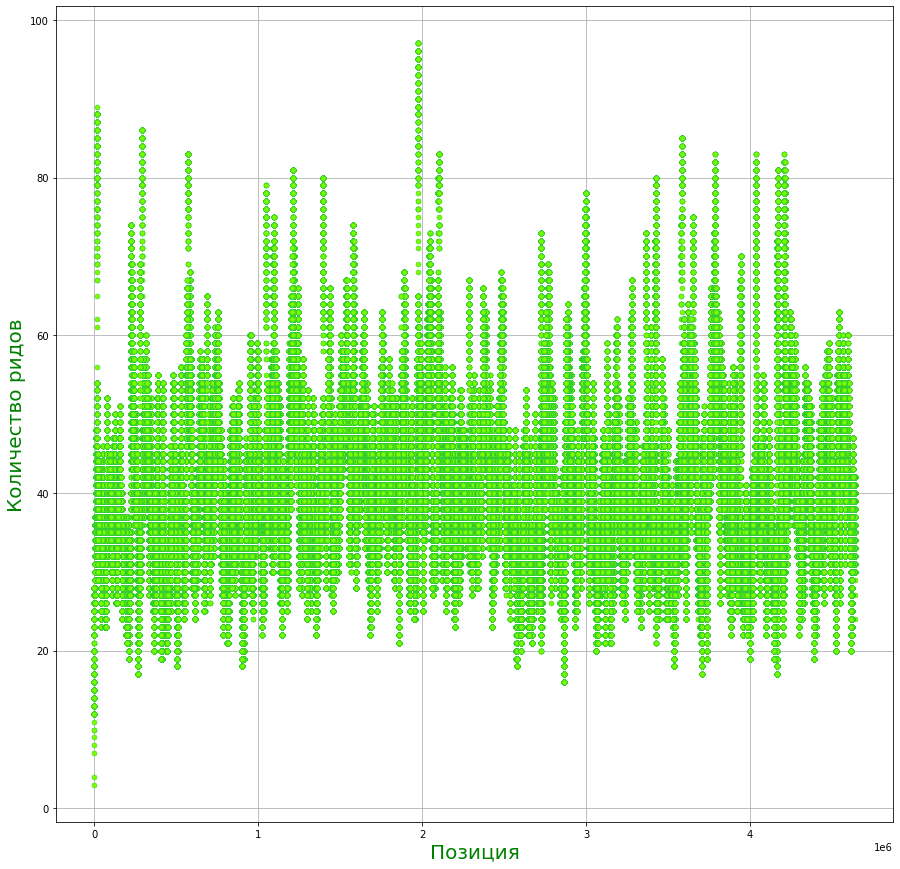

In [12]:
print('Среднее покрытие ', np.array(list(cov_dataset1.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset1.keys()) / len(reference), 15) * 100)
graphics(cov_dataset1)

Для втрого набора данных имеем следующую статистику:

Среднее покрытие  28.325001638046828
Процент покрытого генома  99.99993534029859


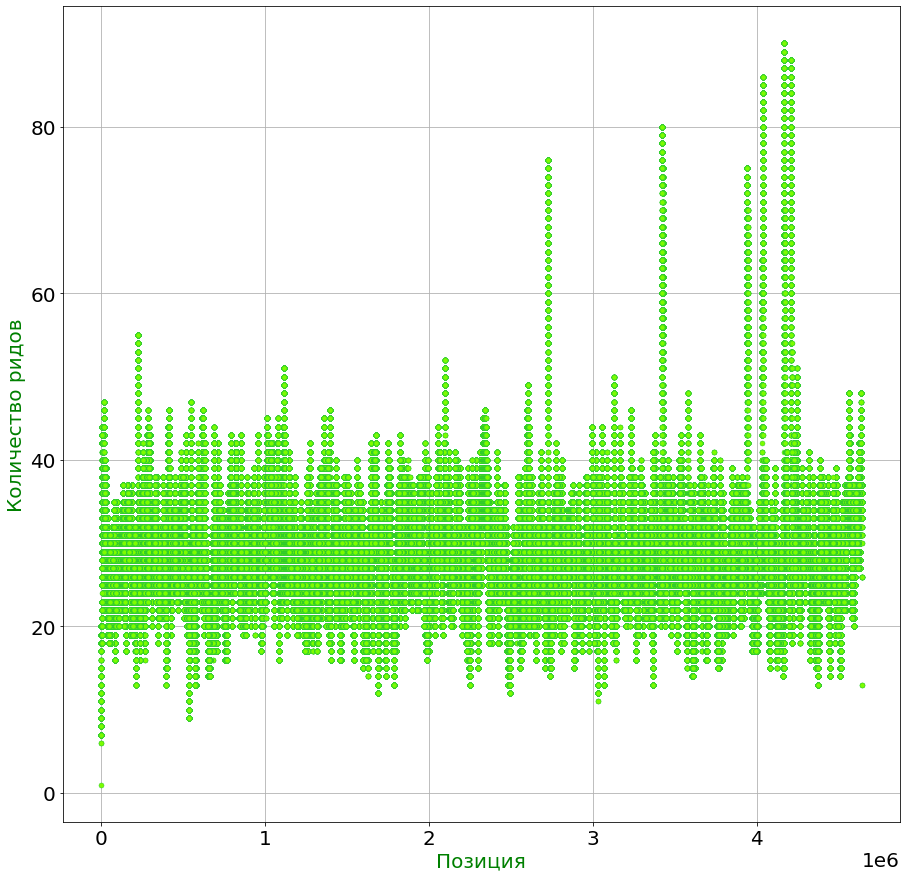

In [13]:
print('Среднее покрытие ', np.array(list(cov_dataset2.values())).mean())
print('Процент покрытого генома ', round(len(cov_dataset2.keys()) / len(reference), 15) * 100)
graphics(cov_dataset2)

- Процент ошибок

In [14]:
import pandas as pd

In [15]:
!samtools view -S -b alignment1.sam > alignment1.bam
!samtools sort alignment1.bam > aligment1_sorted.bam
!samtools index aligment1_sorted.bam

In [19]:
def matrix(sam, ref):
    align = ps.AlignmentFile(sam, threads=4)
    reference = SeqIO.read(ref, 'fasta')
    
    m = {nucl1 : {nucl2 : 0 for nucl2 in ['A', 'G', 'C', 'T', '']} 
          for nucl1 in ['A', 'G', 'C', 'T']}
    
    for col in tqdm(align.pileup()):
        refnucl = reference[col.reference_pos]
        for nucl in ['A', 'C', 'T', 'G', '']:
            m[refnucl][nucl] += Counter(col.get_query_sequences())[nucl]
    return m

def matrix2(m):
    m2 = m
    for col in m2:
        m2[col][col] = '_'
    return m2  

In [25]:
def mean_errors(matrix):
    df = pd.DataFrame(matrix)
    df['sum'] = df.sum(axis=1)
    df = df.div(df["sum"], axis=0)
    df = df.drop('sum', axis=1)
    return (100 * (4 - df['A']['A'] - df['C']['C'] - df['G']['G'] - df['T']['T']))

In [27]:
mat1 = matrix('aligment1_sorted.bam', 'reference.fasta')

4639675it [04:19, 17865.62it/s]


Cредний процент ошибок в ридах для первого набора данных:

In [29]:
mean_errors(mat1)

3.6336429771563705

Матрица частот замен для первого набора данных:

In [30]:
m1 = matrix2(mat1)
df = pd.DataFrame(mat1)
df.drop([''],axis = 0)

,A,G,C,T
A,_,30106,36802,29188
G,20810,_,19351,20305
C,27464,36816,_,23046
T,20696,22493,21578,_


In [22]:
!samtools view -S -b alignment2.sam > alignment2.bam
!samtools sort alignment2.bam > aligment2_sorted.bam
!samtools index aligment2_sorted.bam

In [31]:
mat2 = matrix('aligment2_sorted.bam', 'reference.fasta')

4639675it [05:15, 14721.20it/s]


Средний процент ошибок в ридах для второго набора данных:

In [34]:
mean_errors(mat2)

1.4900739924317952

Матрица частот замен для второго набора данных:

In [36]:
m2 = matrix2(mat2)
df = pd.DataFrame(m2)
df.drop([''],axis = 0)

,A,G,C,T
A,_,27846,10014,7485
G,43571,_,7340,9233
C,9078,5967,_,28768
T,8619,9153,24819,_


- Распределение длин инделов и распределение типов замен

In [47]:
def indel(sam):
    align = ps.AlignmentFile(sam, "r") 

    lenght = []
    insertions =0 
    deletions = 0
    
    for x in align.fetch():
        if x.cigartuples:
            for i, l in x.cigartuples:
                if i == 1:
                    insertions += l
                if i == 2:
                    deletions += l
                if i == 1 or i == 2:
                    lenght.append(l)

    counter = Counter(lenght)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x = list(counter.keys())
    y = list(counter.values())
    count_y = Counter(y)
    p = []
    for Y in y:
        p.append(Y / sum(y))
    p = np.array(p)
    
    
    print('Процент вставок', insertions / sum(lenght), 
          'Процент удалений', deletions / sum(lenght))

    plt.plot(x, p * 100, color='green', linewidth = 1, marker = 'o', 
             markersize = 5, markerfacecolor = 'lawngreen',
             markeredgecolor = 'limegreen', markeredgewidth = 0.5)

    plt.xlabel('Длина индела')
    plt.ylabel('Процент инделов с такой длиной')
    print('Общее количество инделов', sum(y))
    plt.grid()

Процент вставок 0.6972998875477411 Процент удалений 0.302700112452259
Общее количество инделов 16654889


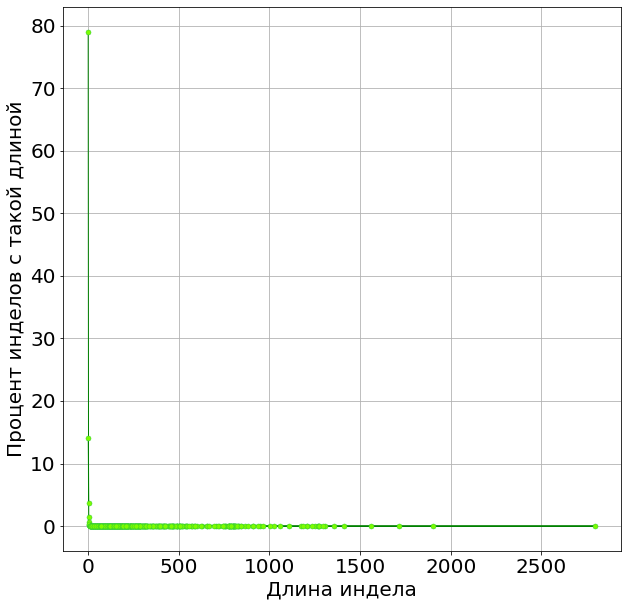

In [48]:
indel('alignment1.sam')

Процент вставок 0.20152445827500362 Процент удалений 0.7984755417249964
Общее количество инделов 4287103


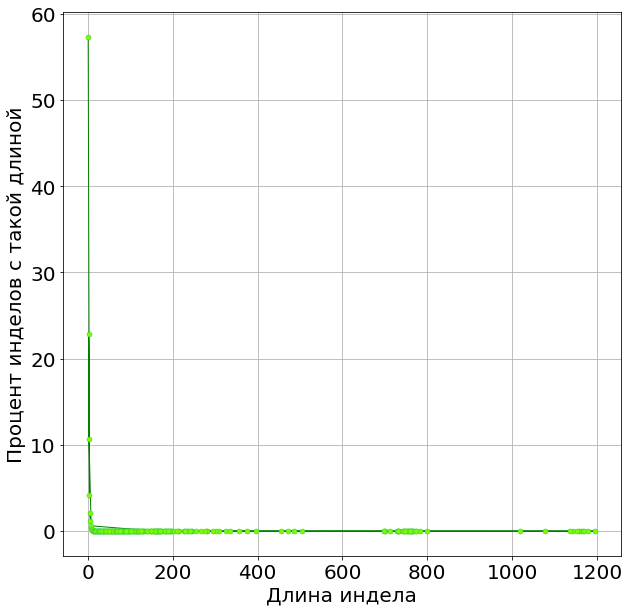

In [49]:
indel('alignment2.sam')